# Modelli ML - E2E

In questa lezione ci occuperemo di allenare e testare diversi modelli di machine learning, in particolare in un contesto di classificazione, sui dati preparati in precedenza.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

## Import dati

Per prima cosa importiamo i dataset di train e test preparati durante la lezione scorsa.

In [2]:
# Definiamo una funzione, utilizzando la sintassi "lambda", per costruire i path che ci servono.
join_paths = lambda csv_path: os.path.join("datasets", csv_path)

train_path = join_paths("train.csv")
test_path = join_paths("test.csv")

display(train_path, test_path)

'datasets/train.csv'

'datasets/test.csv'

In [3]:
# importiamo ora i dati in due DataFrame distinti
train_df, test_df = pd.read_csv(train_path), pd.read_csv(test_path)

In [8]:
# Fissiamo la variabile target
TARGET = "banking_crisis"

# Visualization

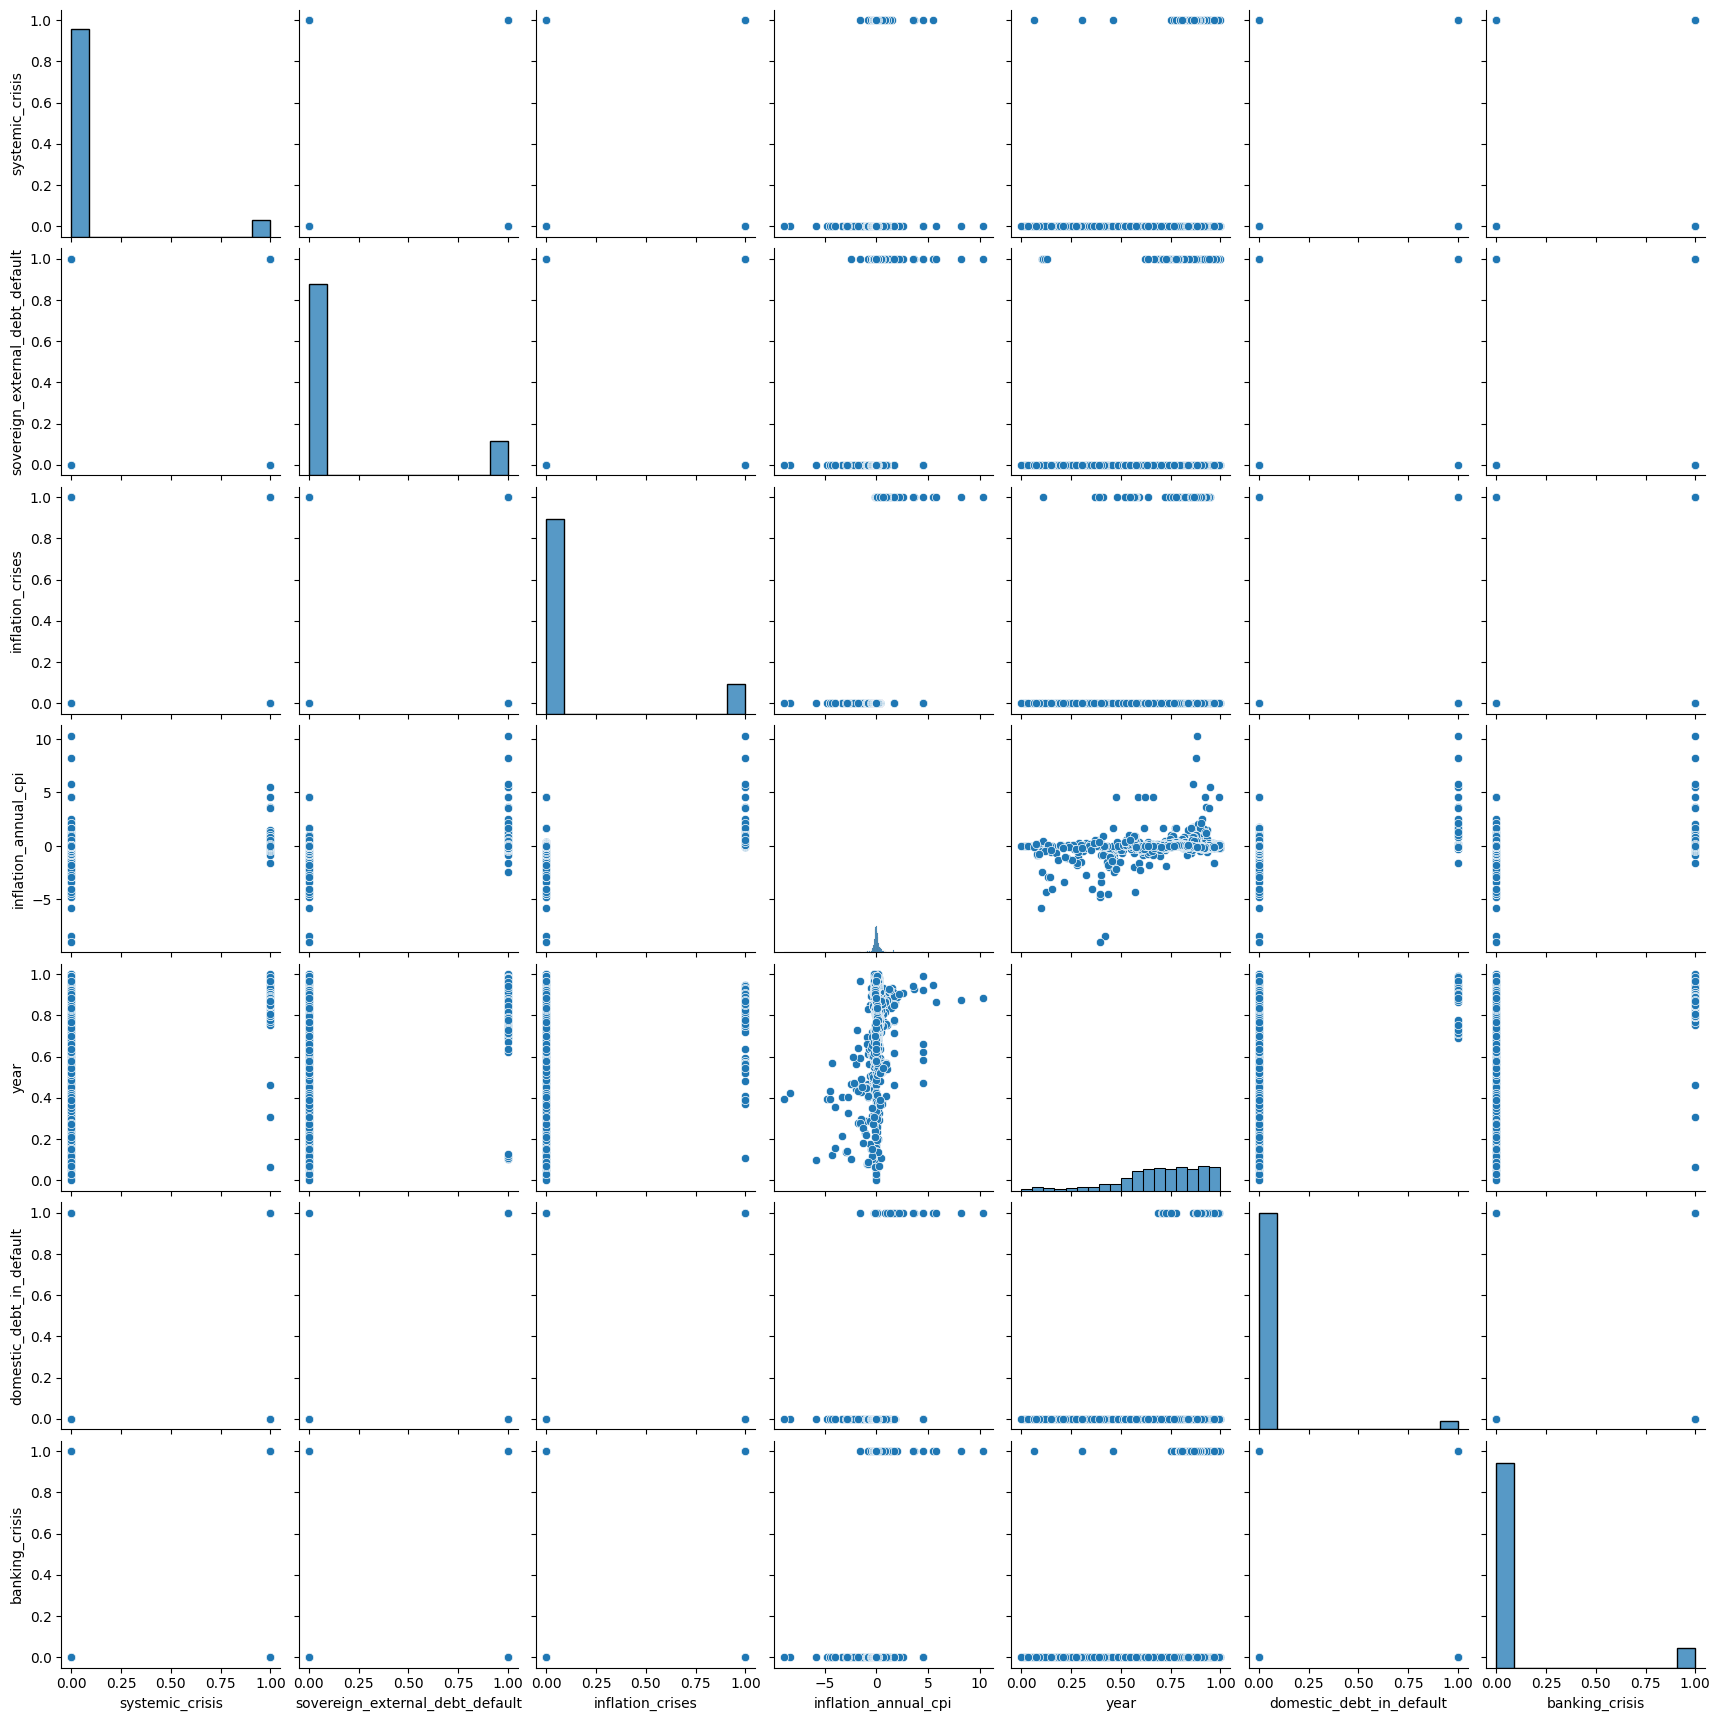

In [4]:
sns.pairplot(train_df)

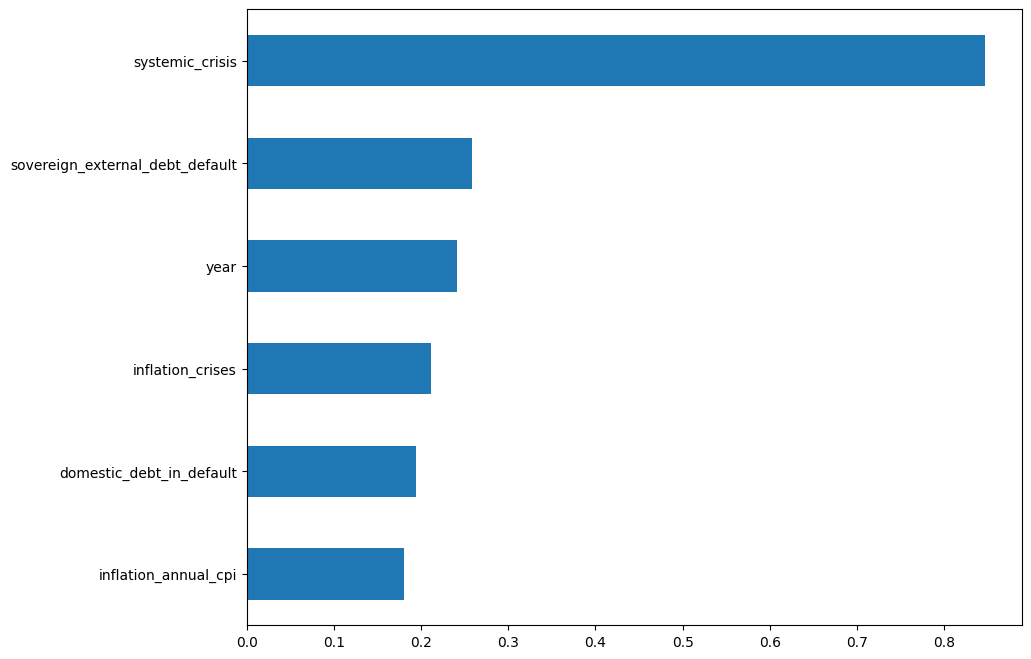

In [10]:
(
    train_df.drop(TARGET, axis=1)
    .corrwith(
        train_df[TARGET], 
        method='spearman'
    )
    .sort_values()
    .plot
    .barh(figsize=[10, 8])
);

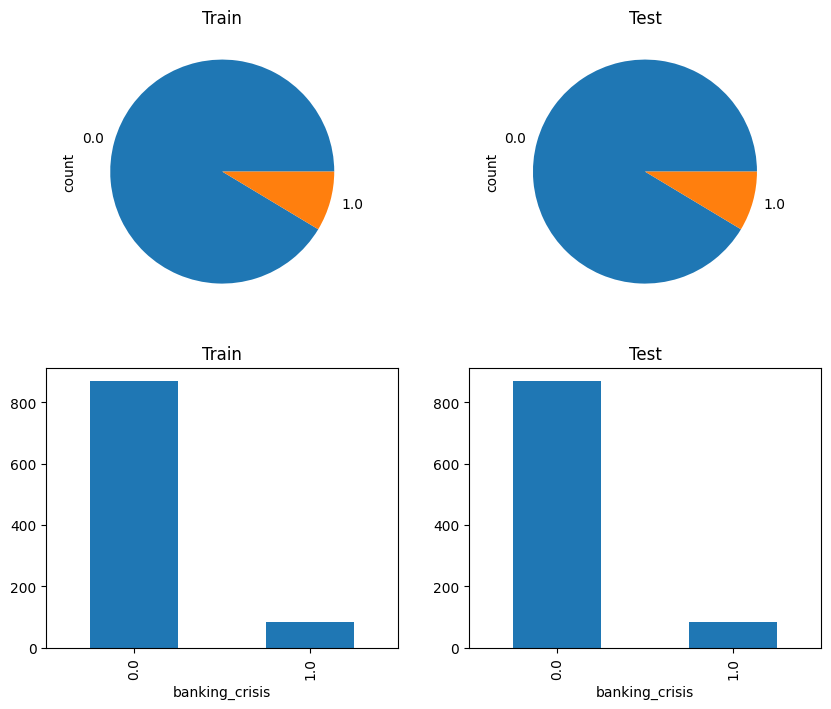

In [34]:
_, (row0, row1) = plt.subplots(2, 2, figsize=[10, 8])
train_df[TARGET].value_counts().plot.pie(ax=row0[0], title="Train");
test_df[TARGET].value_counts().plot.pie(ax=row0[1], title="Test");
train_df[TARGET].value_counts().plot.bar(ax=row1[0], title="Train");
test_df[TARGET].value_counts().plot.bar(ax=row1[1], title="Test");

<Axes: xlabel='year'>

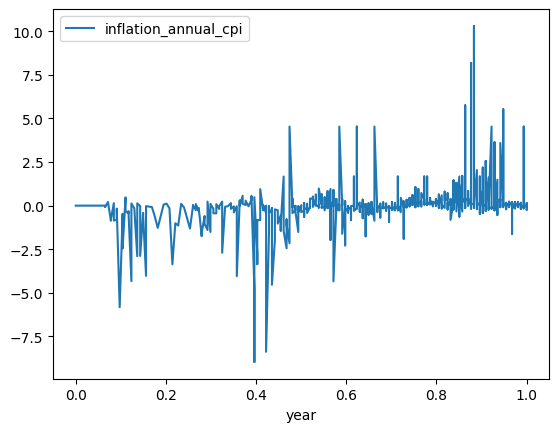

In [39]:
(
    train_df
    [["inflation_annual_cpi", "year"]]
    .sort_values(by=["year"])
    .plot(x="year", y="inflation_annual_cpi")
)

<Axes: xlabel='year', ylabel='banking_crisis'>

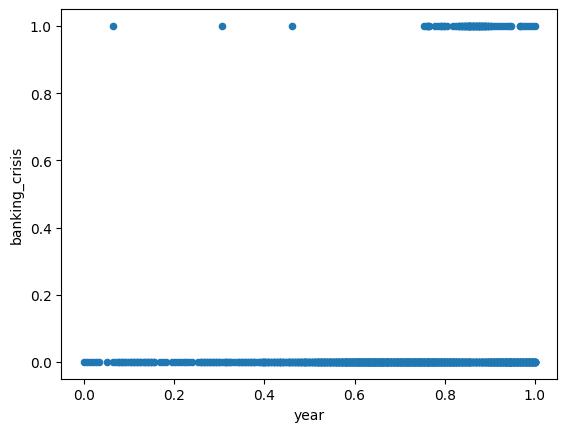

In [44]:
(
    train_df
    [[TARGET, "year"]]
    .sort_values(by=["year"])
    .plot.scatter(x="year", y=TARGET)
)

## Estrazione della variabile target

In questo notebook scegliamo come variabile target `banking_crisis`, la variabile binaria che identifica le osservazioni in cui è in corso una crisi bancaria nel paese. A tal fine separiamo tale colonna dalle feature.

In [4]:
# Definiamo una funzione per lo split
def xy_split(df, target_column):
    x = df.drop(columns=target_column)
    y = df[target_column]
    return x, y


# Separiamo target_column dalle altre feature
X_train, y_train = xy_split(train_df, TARGET)
X_test, y_test = xy_split(test_df, TARGET)

In [5]:
# Controlliamo quali colonne sono presenti nel DataFrame e nella Series risultanti
print(X_train.columns)
print("*"*79)
print(y_train.name)

Index(['Latitude (average)', 'Longitude (average)', 'currency_crises',
       'domestic_debt_in_default', 'exch_usd', 'gdp_weighted_default',
       'independence', 'inflation_annual_cpi', 'inflation_crises',
       'sovereign_external_debt_default', 'systemic_crisis', 'year'],
      dtype='object')
*******************************************************************************
banking_crisis


-----

# Modelli

Adesso andremo ad allenare diversi modelli di classificazione usando il nostro train set e testando le performance sul test set.

## Regressione Logistica

Partiamo da uno dei modelli più semplici: la regressione logistica. Utilizzeremo l'implementazione presente nella libreria `scikit-learn`.

In [6]:
from sklearn.linear_model import LogisticRegression

# Mostriamo alcuni parametri rilevanti
log_reg = LogisticRegression(
    # Termine di regolarizzazione: può essere "l1", "l2", o "elasticnet" (entrambi i termini inclusi)
    penalty="l1", 
    # Stato del generatore di numeri casuali utilizzato dall'oggetto. Utile fissarlo per replicabilità 
    # dei risultati
    random_state=42, 
    # Algoritmo di fitting del modello. Alcune opzioni sono ristrette ad alcuni valori di questa variabile.
    solver="lbfgs",        
    # Massimo numero di iterazioni dell'algoritmo di fitting. Conviene partire dal default 
    # e aumentarlo nel caso non l'algoritmo non converga.
    max_iter=100, 
    # Stampa informazioni durante l'esecuzione.
    verbose=True,   
    # Se penalty='elasticnet' permette di scegliere il rapporto fra i pesi dei due termini 
    # di regolarizzazione.
    l1_ratio=None,              
)

# Metrics
- Confusion Matrix
- Accuracy
- Classification Report
- ROC/AUC